In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d bouweceunen/trained-models-taco-trash-annotations-in-context
!kaggle datasets download -d kneroma/tacotrashdataset

Dataset URL: https://www.kaggle.com/datasets/bouweceunen/trained-models-taco-trash-annotations-in-context
License(s): CC0-1.0
 96% 106M/111M [00:00<00:00, 133MB/s] 
100% 111M/111M [00:00<00:00, 128MB/s]
Dataset URL: https://www.kaggle.com/datasets/kneroma/tacotrashdataset
License(s): other
100% 2.77G/2.79G [00:34<00:00, 115MB/s]
100% 2.79G/2.79G [00:34<00:00, 86.7MB/s]


In [2]:
!unzip tacotrashdataset.zip
!unzip trained-models-taco-trash-annotations-in-context.zip

Archive:  tacotrashdataset.zip
  inflating: best-checkpoint-003epoch.bin  
  inflating: data/annotations.json   
  inflating: data/batch_1/000000.jpg  
  inflating: data/batch_1/000001.jpg  
  inflating: data/batch_1/000003.jpg  
  inflating: data/batch_1/000004.jpg  
  inflating: data/batch_1/000005.jpg  
  inflating: data/batch_1/000006.jpg  
  inflating: data/batch_1/000007.jpg  
  inflating: data/batch_1/000008.jpg  
  inflating: data/batch_1/000010.jpg  
  inflating: data/batch_1/000011.jpg  
  inflating: data/batch_1/000012.jpg  
  inflating: data/batch_1/000013.jpg  
  inflating: data/batch_1/000014.jpg  
  inflating: data/batch_1/000015.jpg  
  inflating: data/batch_1/000016.jpg  
  inflating: data/batch_1/000017.jpg  
  inflating: data/batch_1/000019.jpg  
  inflating: data/batch_1/000021.jpg  
  inflating: data/batch_1/000022.jpg  
  inflating: data/batch_1/000023.jpg  
  inflating: data/batch_1/000024.jpg  
  inflating: data/batch_1/000025.jpg  
  inflating: data/batch_1/000

In [3]:
!rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 70)#ImageFont.truetype('arial.ttf', 400)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && mkdir -p /usr/share/fonts/truetype/dejavu \
    && wget --quiet --show-progress "https://github.com/google/fonts/raw/main/apache/dejavu/DejaVuSans.ttf" -O /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf


Cloning into 'models'...
remote: Enumerating objects: 97156, done.
remote: Counting objects: 100% (436/436), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 97156 (delta 250), reused 382 (delta 224), pack-reused 96720
Receiving objects: 100% (97156/97156), 612.86 MiB | 28.60 MiB/s, done.
Resolving deltas: 100% (70662/70662), done.


In [4]:
!pip install pycocotools


In [5]:
%matplotlib inline
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

from collections import Counter

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)


dataset_path = '/content/data'
anns_file_path = dataset_path + '/' + '/annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

In [6]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [7]:
categories


[{'supercategory': 'Aluminium foil', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'Battery', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'Blister pack', 'id': 2, 'name': 'Aluminium blister pack'},
 {'supercategory': 'Blister pack', 'id': 3, 'name': 'Carded blister pack'},
 {'supercategory': 'Bottle', 'id': 4, 'name': 'Other plastic bottle'},
 {'supercategory': 'Bottle', 'id': 5, 'name': 'Clear plastic bottle'},
 {'supercategory': 'Bottle', 'id': 6, 'name': 'Glass bottle'},
 {'supercategory': 'Bottle cap', 'id': 7, 'name': 'Plastic bottle cap'},
 {'supercategory': 'Bottle cap', 'id': 8, 'name': 'Metal bottle cap'},
 {'supercategory': 'Broken glass', 'id': 9, 'name': 'Broken glass'},
 {'supercategory': 'Can', 'id': 10, 'name': 'Food Can'},
 {'supercategory': 'Can', 'id': 11, 'name': 'Aerosol'},
 {'supercategory': 'Can', 'id': 12, 'name': 'Drink can'},
 {'supercategory': 'Carton', 'id': 13, 'name': 'Toilet tube'},
 {'supercategory': 'Carton', 'id': 14, 'name': 'Other carton'

In [8]:
anns_to_print = anns[0].pop('segmentation', None) # removing segmentation polygon for better clarity
anns[0]

{'id': 1,
 'image_id': 0,
 'category_id': 6,
 'area': 403954.0,
 'bbox': [517.0, 127.0, 447.0, 1322.0],
 'iscrowd': 0}

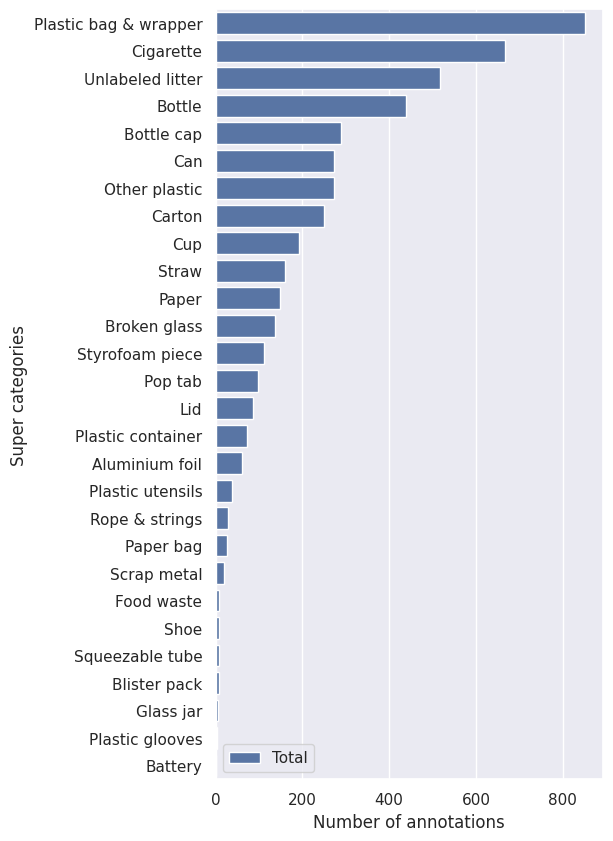

In [9]:
cat_ids_2_supercat_ids = {}
for cat in categories:
    cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]

# Count annotations
super_cat_histogram = np.zeros(nr_super_cats,dtype=int)
for ann in anns:
    cat_id = ann['category_id']
    super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1



# Convert to DataFrame
d = {'Super categories': super_cat_names, 'Number of annotations': super_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values(by='Number of annotations', ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5, 10))

plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
                     label="Total", color="b")


In [10]:
# convert taco label to detect-waste labels
# based on polish recycling standards
def taco_to_detectwaste(label):
    glass = ['Glass bottle','Broken glass','Glass jar']
    metals_and_plastics = ['Aluminium foil', "Clear plastic bottle","Other plastic bottle",
                         "Plastic bottle cap","Metal bottle cap","Aerosol","Drink can",
                         "Food can","Drink carton","Disposable plastic cup","Other plastic cup",
                         "Plastic lid","Metal lid","Single-use carrier bag","Polypropylene bag",
                         "Plastic Film","Six pack rings","Spread tub","Tupperware",
                         "Disposable food container","Other plastic container",
                         "Plastic glooves","Plastic utensils","Pop tab","Scrap metal",
                         "Plastic straw","Other plastic", "Plastic film", "Food Can"]

    non_recyclable = ["Aluminium blister pack","Carded blister pack",
                    "Meal carton","Pizza box","Cigarette","Paper cup",
                    "Meal carton","Foam cup","Glass cup","Wrapping paper",
                    "Magazine paper","Garbage bag","Plastified paper bag",
                    "Crisp packet","Other plastic wrapper","Foam food container",
                    "Rope","Shoe","Squeezable tube","Paper straw","Styrofoam piece", "Rope & strings", "Tissues"]

    other = ["Battery"]
    paper = ["Corrugated carton","Egg carton","Toilet tube","Other carton", "Normal paper", "Paper bag"]
    bio = ["Food waste"]
    unknown = ["Unlabeled litter"]

    if (label in glass):
            label="glass"
    elif (label in metals_and_plastics):
            label="metals_and_plastics"
    elif(label in non_recyclable):
            label="non-recyclable"
    elif(label in other):
            label="other"
    elif (label in paper):
            label="paper"
    elif(label in bio):
            label="bio"
    elif(label in unknown):
            label="unknown"
    else:
        print(label, "is non-taco label")
        label = "unknown"
    return label

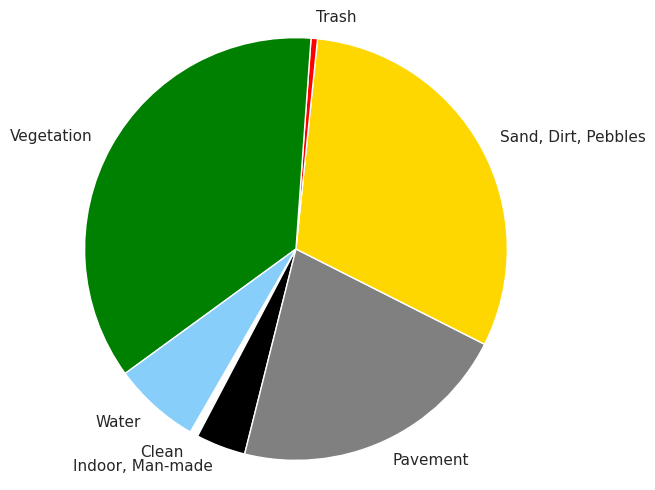

In [11]:
scene_cats = dataset['scene_categories']
scene_name = []
pylab.rcParams['figure.figsize'] = (6,6)

for scene_cat in scene_cats:
    scene_name.append(scene_cat['name'])

nr_scenes = len(scene_cats)
scene_cat_histogram = np.zeros(nr_scenes,dtype=int)

for scene_ann in dataset['scene_annotations']:
    scene_ann_ids = scene_ann['background_ids']
    for scene_ann_id in scene_ann_ids:
        if scene_ann_id<len(scene_cats):
            scene_cat_histogram[scene_ann_id]+=1

# Plot
colors = ['white','black','gray', 'gold', 'red','green','lightskyblue']
plt.pie(scene_cat_histogram, labels=scene_name, colors = colors,
      shadow=False, startangle=-120)

plt.axis('equal')
plt.show()

In [12]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detect waste
detectwaste_categories = dataset['categories']
for ann in anns:
    cat_id = ann['category_id']
    cat_taco = categories[cat_id]['name']
    detectwaste_categories[cat_id]['supercategory'] = taco_to_detectwaste(cat_taco)
# As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories[35]['supercategory'] = taco_to_detectwaste("Plastified paper bag")
detectwaste_categories

[{'supercategory': 'metals_and_plastics', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'other', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'non-recyclable',
  'id': 2,
  'name': 'Aluminium blister pack'},
 {'supercategory': 'non-recyclable', 'id': 3, 'name': 'Carded blister pack'},
 {'supercategory': 'metals_and_plastics',
  'id': 4,
  'name': 'Other plastic bottle'},
 {'supercategory': 'metals_and_plastics',
  'id': 5,
  'name': 'Clear plastic bottle'},
 {'supercategory': 'glass', 'id': 6, 'name': 'Glass bottle'},
 {'supercategory': 'metals_and_plastics',
  'id': 7,
  'name': 'Plastic bottle cap'},
 {'supercategory': 'metals_and_plastics', 'id': 8, 'name': 'Metal bottle cap'},
 {'supercategory': 'glass', 'id': 9, 'name': 'Broken glass'},
 {'supercategory': 'metals_and_plastics', 'id': 10, 'name': 'Food Can'},
 {'supercategory': 'metals_and_plastics', 'id': 11, 'name': 'Aerosol'},
 {'supercategory': 'metals_and_plastics', 'id': 12, 'name': 'Drink can'},
 {'supercategory'

In [13]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1

print(detectwaste_ids)
print(detectwaste_cat_names)

taco_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
#     if cat['id'] not in taco_to_detectwaste_ids:
#         taco_to_detectwaste_ids[cat['id']] = 0
    taco_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]

# print(taco_to_detectwaste_ids)

colors_recykling = ['yellow', 'gray', 'gray', 'green', 'blue', 'brown', 'pink']

anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = taco_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)

{'metals_and_plastics': 0, 'other': 1, 'non-recyclable': 2, 'glass': 3, 'paper': 4, 'bio': 5, 'unknown': 6}
['metals_and_plastics', 'other', 'non-recyclable', 'glass', 'paper', 'bio', 'unknown']


Text(0.5, 1.0, 'Annotations per detectwaste category')

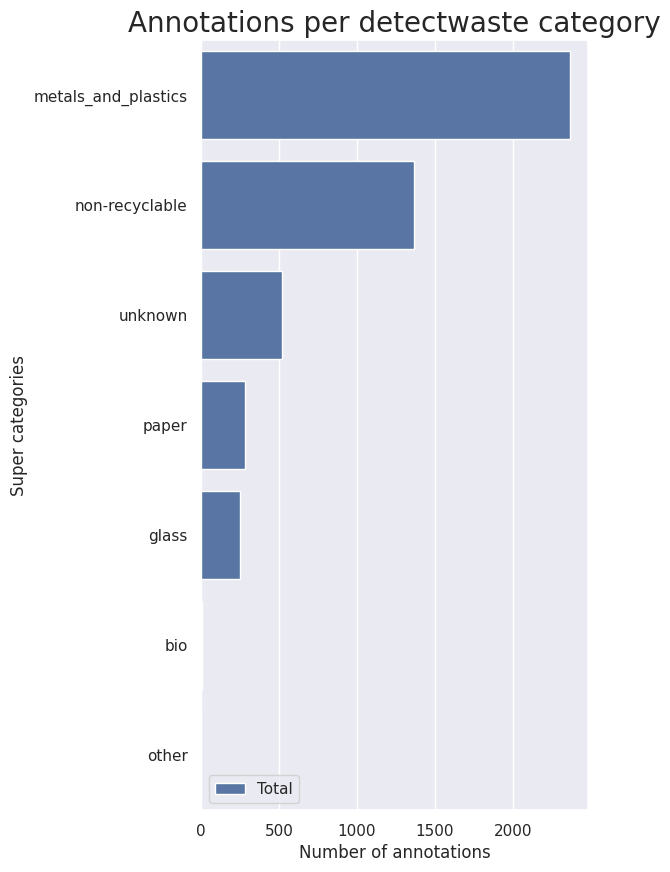

In [14]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1



# Convert to DataFrame
d = {'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values(by='Number of annotations', ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5, 10))

sns.set_palette(sns.color_palette(colors_recykling))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
                     label="Total")
plot_1.set_title('Annotations per detectwaste category', fontsize=20)



In [15]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

In [16]:
#No. of bbox per image
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue

all: 3.1893333333333334

 metals_and_plastics
Maximum bboxes:  33
Mean number of bboxes:  2.0803782505910164
Median number of bboxes:  1.0

 other

 non-recyclable
Maximum bboxes:  25
Mean number of bboxes:  2.1226765799256504
Median number of bboxes:  1.0

 glass
Maximum bboxes:  2
Mean number of bboxes:  1.1
Median number of bboxes:  1.0

 paper
Maximum bboxes:  5
Mean number of bboxes:  1.5128205128205128
Median number of bboxes:  1.0

 bio

 unknown
Maximum bboxes:  9
Mean number of bboxes:  2.0638297872340425
Median number of bboxes:  1.0


<ipython-input-17-ac2a1de1739d>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')


Mean number of annotations per image: 3.1893333333333334


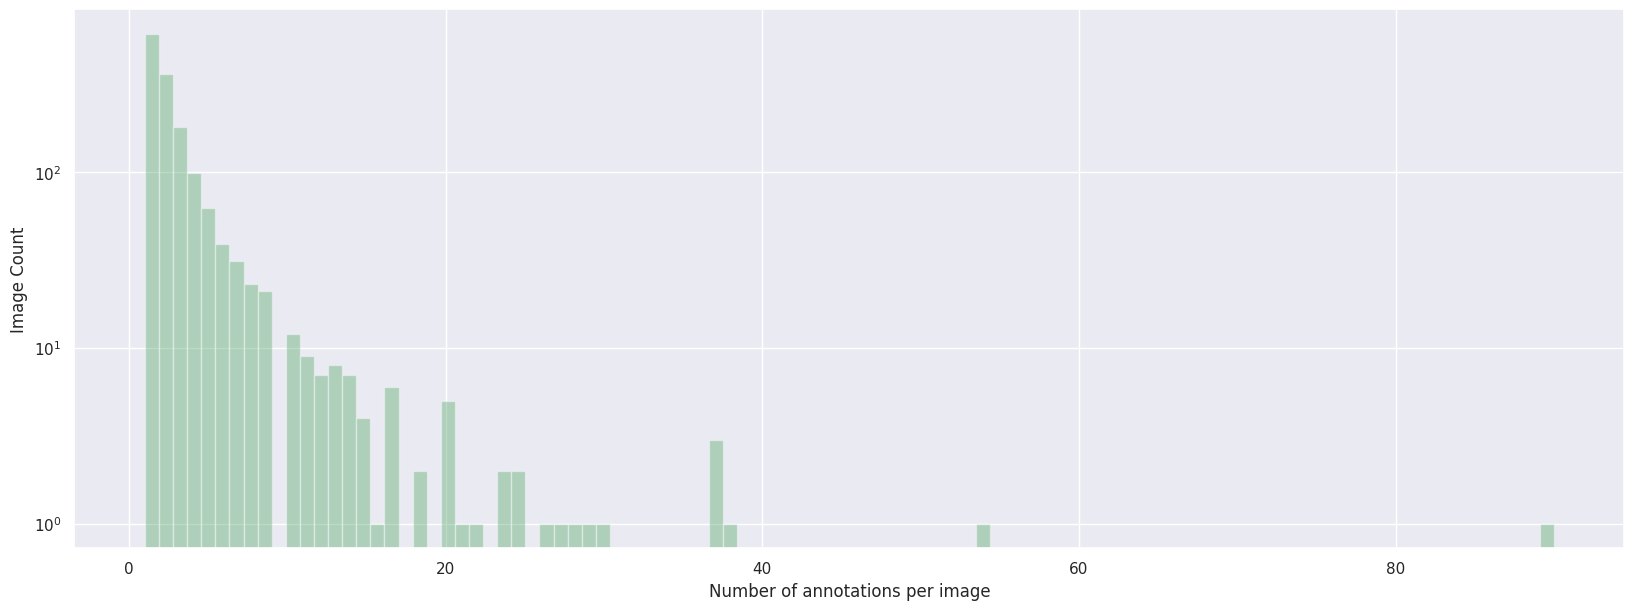

In [17]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))
plt.figure(figsize=(20,7))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
ax.set(xlabel='Number of annotations per image', ylabel='Image Count')

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

In [18]:
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .


Usage:   
  /usr/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/bin/python3 -m pip install [options] <archive url/path> ...

option --use-feature: invalid choice: '2020-resolver' (choose from 'fast-deps', 'truststore', 'no-binary-enable-wheel-cache')


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat

from google.protobuf import text_format
import pprint
import json
import os

In [20]:
!pip install --upgrade protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-aiplatform 1.48.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google

In [21]:
from tensorflow.core.protobuf import saved_model_pb2

In [22]:
import sys
sys.path.append('/content/models/research')
sys.path.append('/content/models/research/slim')


In [23]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2


In [24]:
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [25]:
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )
            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

In [26]:
import os
DATA_DIR = '/content/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [27]:
import json
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)

categories = data['categories']

In [28]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [29]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [30]:
detection_graph = reconstruct("/content/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


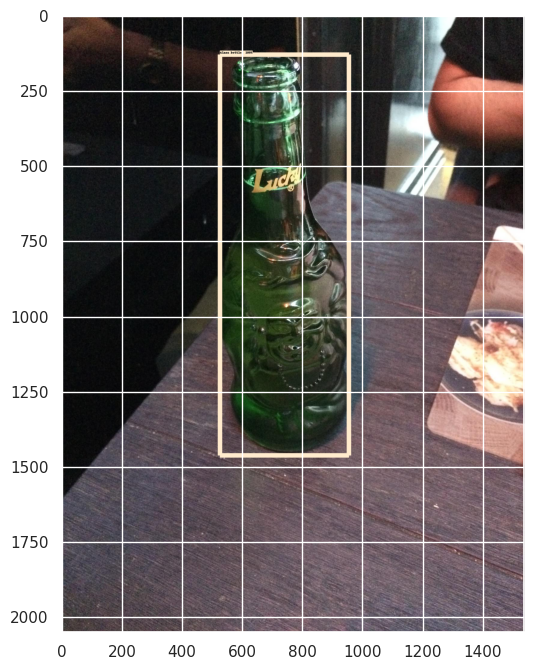

In [31]:
detect(detection_graph, '/content/data/batch_1/000006.jpg')

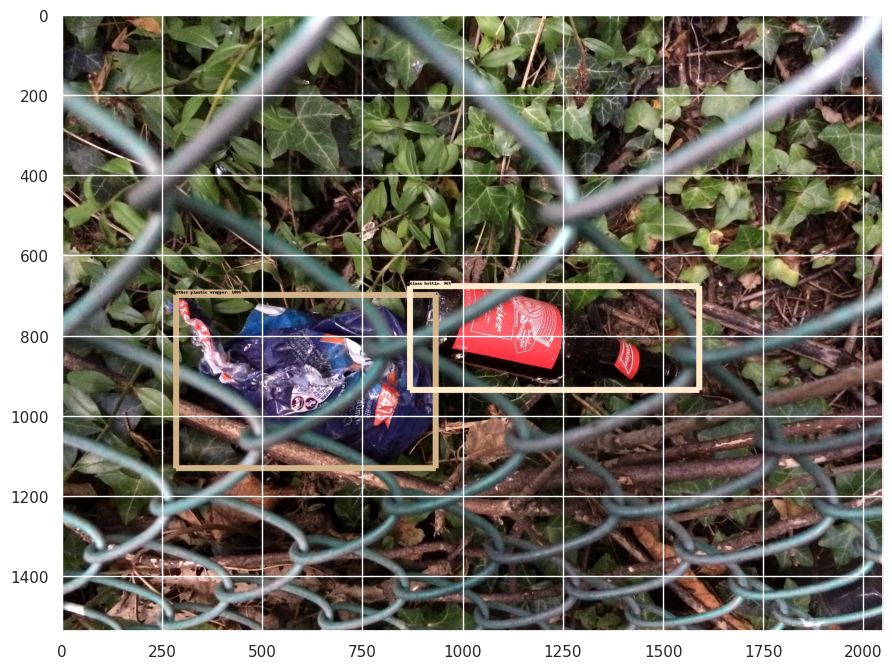

In [32]:
detect(detection_graph, '/content/data/batch_1/000021.jpg')

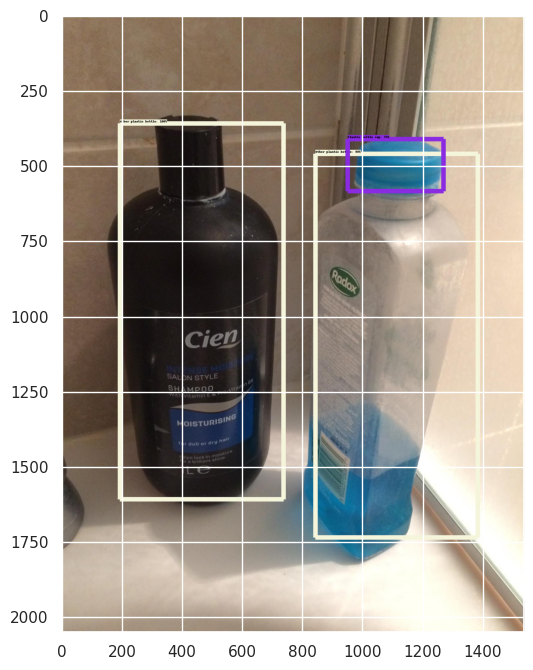

In [33]:
detect(detection_graph, '/content/data/batch_1/000058.jpg')

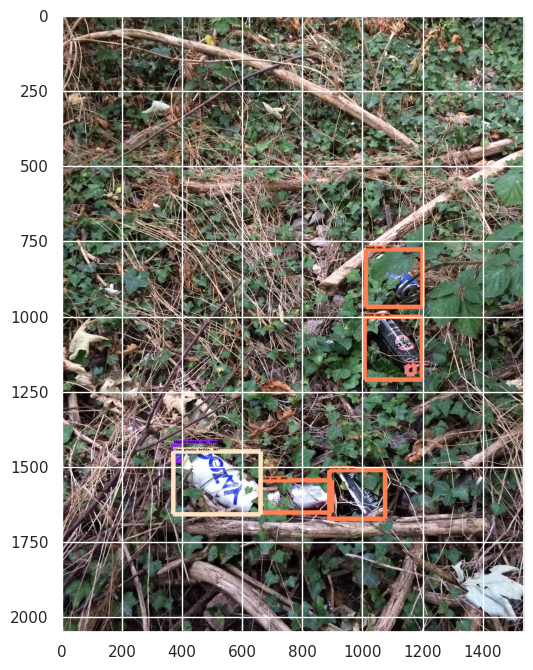

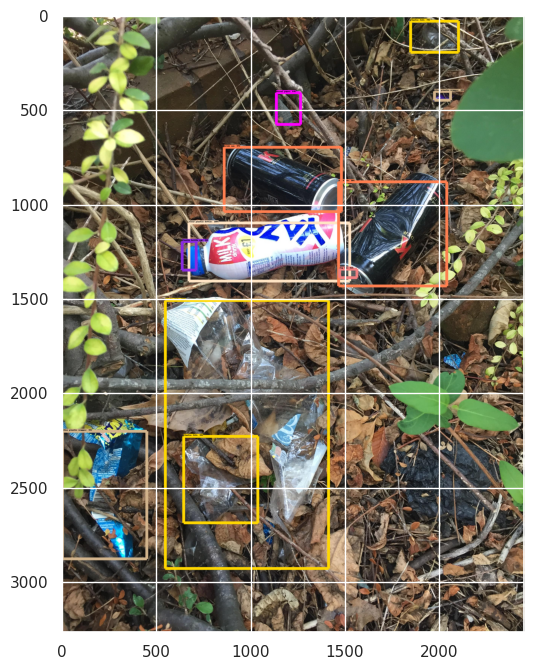

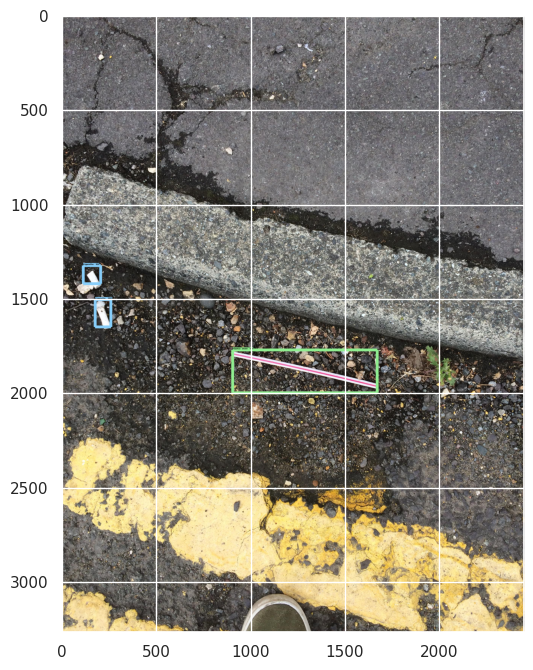

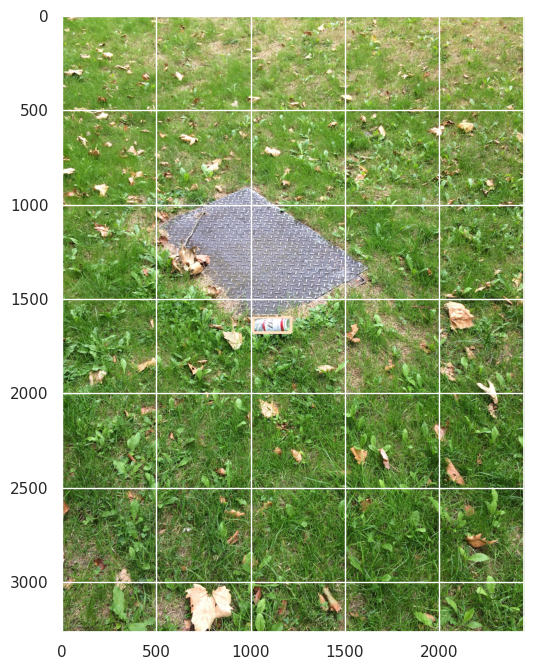

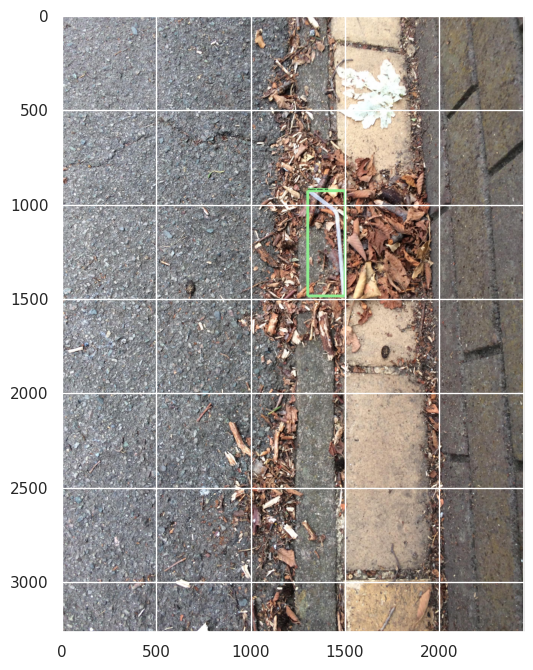

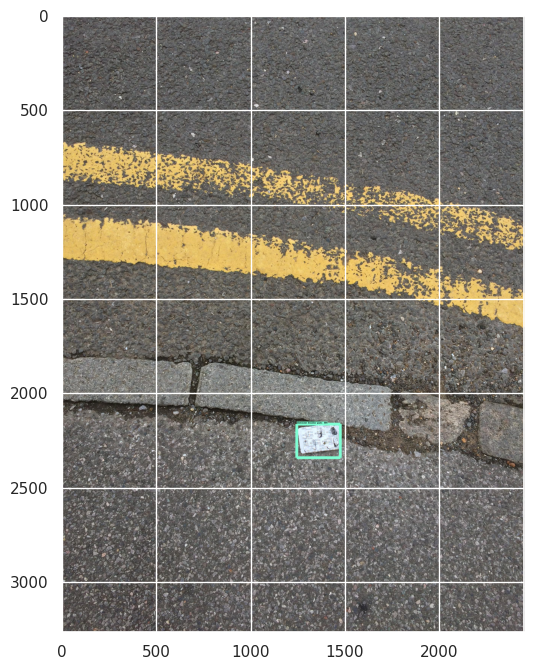

In [34]:
detect(detection_graph, '/content/data/batch_1/000023.jpg')
detect(detection_graph, '/content/data/batch_1/000062.JPG')
detect(detection_graph, '/content/data/batch_1/000068.JPG')
detect(detection_graph, '/content/data/batch_2/000046.JPG')
detect(detection_graph, '/content/data/batch_2/000085.JPG')
detect(detection_graph, '/content/data/batch_3/IMG_4907.JPG')